In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lattice import Triangular_Lattice 

%load_ext autoreload
%matplotlib inline

## Visualize Moire Potential

<a list of 90 text.Text objects>

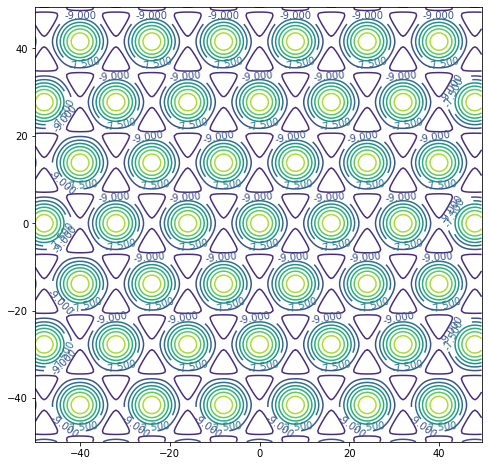

In [2]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)

## Parameterize random walkers

In [3]:
%autoreload 2
from walker import Graphene_Walker
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
walkers = Graphene_Walker(0.246, 15) # 2.46 Angstrom lattice, 10 Kelvin
tracks = walkers.get_tracks(moire, nsteps=300, njumps=100000, nparticles=100)

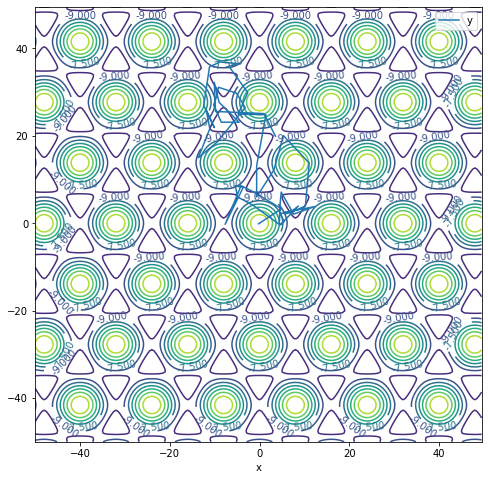

In [4]:
%autoreload 2
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

delta = 0.5
x = np.arange(-50, 50, delta)
y = np.arange(-50, 50, delta)
X, Y = np.meshgrid(x, y)
moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1eV energy amplitude
Z = moire.U(X, Y)
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=1, fontsize=10)
tracks[tracks['particle'] == 0].plot(x = 'x', y='y', ax=ax)

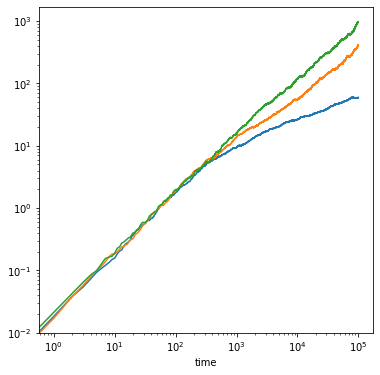

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for temperature in [2, 5, 10]:
    moire = Triangular_Lattice(16, 1) # 16nm lattice constant, 1meV energy amplitude
    walkers = Graphene_Walker(0.246, temperature) # 2.46 Angstrom lattice, 10 Kelvin
    tracks = walkers.get_tracks(moire, nsteps=100000, njumps=100000, nparticles=100, endT=1e5)
    tracks.groupby('time')['r^2'].mean().plot(ax=ax)
    x = np.linspace(1, tracks.time.max())
    ax.set_xscale("log")
    ax.set_yscale("log")

## Temperature Plots (figure 3)

In [5]:
from utils import *

In [20]:
temperatures = range(4,10)
periodicity = [4, 8, 12, 16]

period_temp_activations = []
period_temp_predictions = []
period_temp_values = []
period_num_fbm = []
period_num_brownian = []
period_num_ctrw = []
 

for period in periodicity:
    all_temp_activations = []
    all_temp_predictions = []
    all_temp_values = []
    num_fbm = []
    num_brownian = []
    num_ctrw = []
    for temp in temperatures:
        
        ## generate tracks at that temperature
        moire = Triangular_Lattice(period, 2) # 16nm lattice constant, 1meV energy amplitude
        walkers = Graphene_Walker(0.246, temp) # 2.46 Angstrom lattice, 10 Kelvin
        tracks = walkers.get_tracks(moire, nsteps=50, njumps=100000, nparticles=400, endT=1e5)

        ## gather x and y values
        x = []
        y = []
        for particle in list(set(tracks['particle'])):
            x.append(np.array(tracks[tracks['particle'] == particle]['x']))
            y.append(np.array(tracks[tracks['particle'] == particle]['y']))
        x = np.array(x)
        y = np.array(y)

        ## calculate dx and y
        temp_x = x-np.mean(x)
        temp_dx = np.diff(temp_x)
        temp_dx = temp_dx/np.std(temp_dx)

        print(temp_dx)
        ## trim x and y to shape
        temp_dx = temp_dx[:,::int(temp_dx.shape[1] / 50)][:,:-1]

        temp_values, temp_predictions = classification_on_real(temp_dx)
        all_temp_activations.append(get_activations(temp_dx))

        num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
        num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
        num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))

        all_temp_predictions.append(temp_predictions)
        all_temp_values.append(temp_values)
    period_temp_activations.append(all_temp_activations)
    period_temp_predictions.append(all_temp_predictions)
    period_temp_values.append(all_temp_values)
    period_num_fbm.append(num_fbm)
    period_num_brownian.append(num_brownian)
    period_num_ctrw.append(num_ctrw)
    
all_temp_activations = np.array(all_temp_activations)

[[-3.26084050e+00 -2.96440046e-01 -1.03754016e+00 ... -1.48220023e-01
   4.44660069e-01 -7.41100115e-01]
 [ 1.18576018e+00  0.00000000e+00 -4.44660069e-01 ... -8.89320137e-01
  -2.22330034e+00  4.44660069e-01]
 [-1.92686030e+00 -2.96440046e-01  4.63449713e-16 ... -4.44660069e-01
  -4.44660069e-01 -9.26899426e-16]
 ...
 [-1.33398021e+00  1.18576018e+00 -2.96440046e-01 ...  7.41100115e-01
   0.00000000e+00 -4.44660069e-01]
 [ 2.07508032e+00  1.33398021e+00  5.92880092e-01 ... -8.89320137e-01
  -7.41100115e-01  1.63042025e+00]
 [ 4.00194062e+00 -5.92880092e-01  8.89320137e-01 ... -5.92880092e-01
  -8.89320137e-01  0.00000000e+00]]
[[-1.24954254e+00 -1.92237314e+00  2.88355971e-01 ... -1.15342388e+00
  -5.76711942e-01  8.65067913e-01]
 [-2.01849180e+00  2.01849180e+00  2.88355971e-01 ...  2.40296643e+00
  -6.72830599e-01 -2.21072911e+00]
 [-2.88355971e-01  1.92237314e-01 -1.15342388e+00 ... -2.88355971e-01
  -8.65067913e-01  1.34566120e+00]
 ...
 [-9.61186570e-01 -1.05730523e+00 -3.8447462

[[-1.74524438 -0.96958021 -0.38783208 ... -2.26235382 -3.10265667
   2.65018591]
 [-3.36121139 -0.77566417 -0.38783208 ... -0.64638681 -1.55132834
  -0.3231934 ]
 [ 1.6806057  -0.3231934   0.58174813 ... -0.58174813 -1.29277361
   0.        ]
 ...
 [ 0.71102549  0.96958021  0.84030285 ...  0.12927736  0.64638681
  -2.58554723]
 [ 1.55132834 -0.58174813 -0.06463868 ...  0.58174813  0.96958021
  -0.90494153]
 [-0.64638681  1.03421889  0.58174813 ... -0.12927736  0.3231934
   0.19391604]]
[[ 4.24472118  0.68976719  0.10611803 ...  1.32647537 -0.63670818
   0.        ]
 [ 3.13048187  0.05305901  1.0611803  ... -0.3714131  -0.10611803
  -0.31835409]
 [ 0.47753113 -2.28153764 -1.4325934  ... -0.15917704  0.47753113
   0.53059015]
 ...
 [-2.06930158  4.2977802   1.53871143 ... -0.15917704 -0.79588522
   2.33459665]
 [ 2.06930158  1.53871143 -2.81212778 ...  0.31835409 -1.16729833
   0.79588522]
 [-2.28153764 -0.42447212 -1.16729833 ... -1.16729833  0.21223606
  -0.53059015]]
[[ 2.73919121 -0.

Text(0.5, 1.0, 'Temperature vs Proportion of Class')

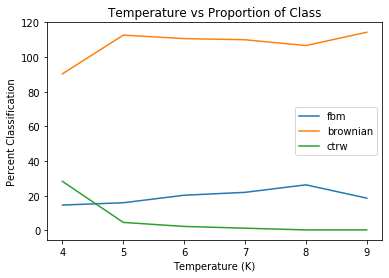

In [26]:
x = temperatures
plt.plot(x, np.array(period_num_fbm[0]) / 3, c="tab:blue",label="fbm")
plt.plot(x, np.array(period_num_brownian[0]) / 3, c="tab:orange", label="brownian")
plt.plot(x, np.array(period_num_ctrw[0]) / 3, c="tab:green",label="ctrw")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Percent Classification")
plt.title("Temperature vs Proportion of Class")

## UMap

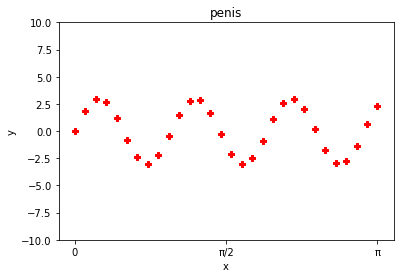

In [43]:
x = np.linspace(0, np.pi, 30)
y = 3 * np.sin(2 * np.pi * x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ylim((-10, 10))


# plot the function
plt.scatter(x,y, marker="P", color="r")
plt.xlabel("x")
plt.ylabel("y")
plt.title("penis")
plt.xticks([0, np.pi/2, np.pi], ["0", "π/2", "π"])
# show the plot
plt.show()

In [7]:
def manifold(dx, predictions, s=30, ax=None, markers = ["o",">","s"], color="tab:blue", fbm_coeffs=None, ctrw_alphas=None, embedding_name="tsne"):
    if embedding_name == "tsne":
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    else:
        embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)
    
    fbm_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 0])
    ctrw_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 2])
    brownian_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 1])

    fbm = None
    ctrw = None
    brownian = None
    plt_list = []
    plt_names = []
    if ax is None:
        ax = plt.axes()
        ax.figure.set_size_inches(12,8)
    if fbm_points.size != 0:
        if fbm_coeffs is not None:
            cmap = sns.cubehelix_palette(as_cmap=True)
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, 
                             c=fbm_coeffs*2,marker=markers[0], edgecolors='black',cmap=cmap)
        else:
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, c=color,marker=markers[0], edgecolors='black')
        plt_list.append(fbm)
        plt_names.append("fbm")
    if ctrw_points.size != 0:
        if ctrw_alphas is not None:
            cmap = sns.cubehelix_palette(as_cmap=True, rot=-0.4)
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, 
                              c=ctrw_alphas, marker=markers[1], edgecolors='black', cmap=cmap)
        else:
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, c=color, marker=markers[1], edgecolors='black')
        plt_list.append(ctrw)
        plt_names.append("ctrw")
    if brownian_points.size != 0:
        brownian = ax.scatter(brownian_points[:,0], brownian_points[:,1], s=s, c=color, marker=markers[2],edgecolors='black')
        plt_list.append(brownian)
        plt_names.append("brownian")

    plt.legend(plt_list, plt_names)
    return ctrw, ax

In [ ]:
marker_size = 80
colors = sns.cubehelix_palette(9)
ctrw1, ax = tsne(all_temp_activations[4], all_temp_predictions[4], s = marker_size, color=colors[0])
ctrw2, ax = tsne(all_temp_activations[8], all_temp_predictions[8], s = marker_size, ax=ax, color=colors[2])
ctrw3, ax = tsne(all_temp_activations[12], all_temp_predictions[12], s = marker_size, ax=ax, color=colors[4])